In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use ('ggplot')
import seaborn as sns
%matplotlib inline
sns.set_style(style="whitegrid")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from bs4 import BeautifulSoup

import nltk, string, contractions

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

from operator import itemgetter

In [2]:
df = pd.read_csv('data/modeling_ready_microwave1')

In [3]:
df.head()

,customer_id,review_id,product_id,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date,review_wordcount,clean_review
0,44300577,R2ZU11YALTJNZX,B0009KMYHI,1.0,0.0,0.0,Y,I have had this microwave for just over 3 year...,I have had this microwave for just over 3 year...,2015-08-31,91,I have had this microwave for just over 3 year...
1,50952586,RVBITZNBVJ8AI,B0009KMYHI,5.0,0.0,0.0,Y,It takes a good bit of room on the counter,Man this thing cooks evenly and fast! It takes...,2015-08-30,23,Man this thing cooks evenly and fast! It takes...
2,31144708,R44LZL0OR5EWP,B0009KMYDM,5.0,0.0,0.0,Y,Five Stars,Works great! Have had it over a year and no su...,2015-08-30,17,Works great! Have had it over a year and no su...
3,14667788,RPWWYNUD9X64U,B0009KMYHI,5.0,0.0,0.0,Y,... received this several years ago and it sti...,I ordered and received this several years ago ...,2015-08-29,13,I ordered and received this several years ago ...
4,25468208,RS76DCCGM685B,B0009KMYGY,1.0,3.0,3.0,Y,Avoid Panasonic - Doors Don't Close,I have had this microwave for just over 2 year...,2015-08-28,131,I have had this microwave for just over 2 year...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        1875 non-null   int64  
 1   review_id          1875 non-null   object 
 2   product_id         1875 non-null   object 
 3   star_rating        1875 non-null   float64
 4   helpful_votes      1875 non-null   float64
 5   total_votes        1875 non-null   float64
 6   verified_purchase  1875 non-null   object 
 7   review_headline    1875 non-null   object 
 8   review_body        1875 non-null   object 
 9   review_date        1875 non-null   object 
 10  review_wordcount   1875 non-null   int64  
 11  clean_review       1875 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 175.9+ KB


In [5]:
df.review_date = pd.to_datetime(df.review_date)

In [6]:
df.describe()

,customer_id,star_rating,helpful_votes,total_votes,review_wordcount
count,1.875000e+03,1875.000000,1875.000000,1875.000000,1875.000000
mean,3.209401e+07,3.850133,3.107733,3.628267,80.606933
std,1.476223e+07,1.496151,20.062047,20.926332,97.269705
min,8.722000e+04,1.000000,0.000000,0.000000,1.000000
25%,1.748780e+07,3.000000,0.000000,0.000000,28.000000
50%,3.303278e+07,5.000000,1.000000,1.000000,51.000000
75%,4.624525e+07,5.000000,2.000000,2.000000,94.000000
max,5.309426e+07,5.000000,589.000000,599.000000,1152.000000


In [7]:
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")
def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

In [8]:
def nlp_prep(df):
    # lowercase everything
    # get rid of '\n' from whitespace
    # regex remove hyperlinks
    # remove punctuation
    # remove ' s ' from removing punctuation
    
    # lowercase everything
    df['model_ready'] = df['clean_review'].apply(lambda x: x.lower())
    # expand contractions
    df['model_ready'] = df['model_ready'].apply(lambda x:[contractions.fix(word) for word in x.split()])
    df['model_ready'] = [' '.join(map(str, l)) for l in df['model_ready']]
    # get rid of '\n' from whitespace 
    df['model_ready'] = df['model_ready'].apply(lambda x: x.replace('\n', ' '))
    # regex remove hyperlinks
    df['model_ready'] = df['model_ready'].str.replace('http\S+|www.\S+', '', case=False)
    # remove punctuations
    df['model_ready'] = df['model_ready'].apply(remove_punctuations)
    # remove ' s ' that was created after removing punctuations
    df['model_ready'] = df['model_ready'].apply(lambda x: str(x).replace(" s ", " "))
    return df

In [9]:
nlp_prep(df)

,customer_id,review_id,product_id,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date,review_wordcount,clean_review,model_ready
0,44300577,R2ZU11YALTJNZX,B0009KMYHI,1.0,0.0,0.0,Y,I have had this microwave for just over 3 year...,I have had this microwave for just over 3 year...,2015-08-31,91,I have had this microwave for just over 3 year...,i have had this microwave for just over 3 year...
1,50952586,RVBITZNBVJ8AI,B0009KMYHI,5.0,0.0,0.0,Y,It takes a good bit of room on the counter,Man this thing cooks evenly and fast! It takes...,2015-08-30,23,Man this thing cooks evenly and fast! It takes...,man this thing cooks evenly and fast it takes...
2,31144708,R44LZL0OR5EWP,B0009KMYDM,5.0,0.0,0.0,Y,Five Stars,Works great! Have had it over a year and no su...,2015-08-30,17,Works great! Have had it over a year and no su...,works great have had it over a year and no su...
3,14667788,RPWWYNUD9X64U,B0009KMYHI,5.0,0.0,0.0,Y,... received this several years ago and it sti...,I ordered and received this several years ago ...,2015-08-29,13,I ordered and received this several years ago ...,i ordered and received this several years ago ...
4,25468208,RS76DCCGM685B,B0009KMYGY,1.0,3.0,3.0,Y,Avoid Panasonic - Doors Don't Close,I have had this microwave for just over 2 year...,2015-08-28,131,I have had this microwave for just over 2 year...,i have had this microwave for just over 2 year...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870,33705501,R34GY91QSWWUE4,B0009KMYGY,4.0,60.0,64.0,N,Just right for me...,The Panasonic NN-H765WF was exactly what I was...,2006-03-23,74,The Panasonic NN-H765WF was exactly what I was...,the panasonic nn h765wf was exactly what i was...
1871,39268146,R7N1LRCV8GU6L,B0009KMYHI,5.0,5.0,10.0,Y,good looking-good cooking,this microwave cooks food very evenly-no need ...,2006-03-19,21,this microwave cooks food very evenly-no need ...,this microwave cooks food very evenly no need ...
1872,19314267,R15KWS9QSI7URC,B0009KMYDM,5.0,12.0,13.0,Y,Panasonic NN-H965WF Luxury full-size 2.2 cu.ft...,"its a great microwave , i use it every day , i...",2006-03-16,67,"its a great microwave , i use it every day , i...",its a great microwave i use it every day i...
1873,11400155,RK5HSUM1GNRH8,B0009KMYDM,5.0,4.0,9.0,N,Panasonic Microwave Oven NN-965WF,Have had it for only a short time but it has p...,2006-02-24,20,Have had it for only a short time but it has p...,have had it for only a short time but it has p...


In [10]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [11]:
keep_words = ['not', 'ain', 'aren', "aren't", 'couldn', "couldn't", 
              'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 
              'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
              'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
              "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
              'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 
              'wouldn', "wouldn't", 'fire', 'off']

In [12]:
test_stop_words = ['great', 'excellent', '1', '2', 'feature', 'nice', 'old']
review_stop_words = ['panasonic', 'really', 'husband', 'thanks', 'thank', 'ha', 
              'just', 'thing', 'did', 'nn', 'wa', 'yr', 'u', 'say', 'doe',
              'mom', 'christmas', 'gift', 'got', 'way', 'le', 'daughter',
              'e','not','love','good','bought','great microwave','micro',
              'great oven','microwave','product','work great','nice work',
              'work great use','work great love','feature work great',
              'unit work great','oven work great','easy use love','old oven',
              'old old','20 year old','unit', 'not', 'work', 'amazon', 'com',
              'old', 'wife', 'highly', 'recommend', 'like', 'charm',
                '20', 'easy', 'oven', 'use', 'year']
for _ in text.ENGLISH_STOP_WORDS:
    if _ in keep_words:
        pass
    else:
        review_stop_words.append(_)
for _ in test_stop_words:
    review_stop_words.append(_)

In [13]:
len(review_stop_words)

381

In [14]:
vectorizer = TfidfVectorizer(tokenizer = lemmatize_text,
                             stop_words= review_stop_words,
                             max_features = 10000,
                             min_df = 3,
                             max_df =  .8,
                             ngram_range=(0, 2)
                            )

In [15]:
X = df['model_ready']

In [16]:
X = vectorizer.fit_transform(X)

In [17]:
X.shape

(1875, 3908)

In [18]:
df.head()

,customer_id,review_id,product_id,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date,review_wordcount,clean_review,model_ready
0,44300577,R2ZU11YALTJNZX,B0009KMYHI,1.0,0.0,0.0,Y,I have had this microwave for just over 3 year...,I have had this microwave for just over 3 year...,2015-08-31,91,I have had this microwave for just over 3 year...,i have had this microwave for just over 3 year...
1,50952586,RVBITZNBVJ8AI,B0009KMYHI,5.0,0.0,0.0,Y,It takes a good bit of room on the counter,Man this thing cooks evenly and fast! It takes...,2015-08-30,23,Man this thing cooks evenly and fast! It takes...,man this thing cooks evenly and fast it takes...
2,31144708,R44LZL0OR5EWP,B0009KMYDM,5.0,0.0,0.0,Y,Five Stars,Works great! Have had it over a year and no su...,2015-08-30,17,Works great! Have had it over a year and no su...,works great have had it over a year and no su...
3,14667788,RPWWYNUD9X64U,B0009KMYHI,5.0,0.0,0.0,Y,... received this several years ago and it sti...,I ordered and received this several years ago ...,2015-08-29,13,I ordered and received this several years ago ...,i ordered and received this several years ago ...
4,25468208,RS76DCCGM685B,B0009KMYGY,1.0,3.0,3.0,Y,Avoid Panasonic - Doors Don't Close,I have had this microwave for just over 2 year...,2015-08-28,131,I have had this microwave for just over 2 year...,i have had this microwave for just over 2 year...


In [44]:
nmf = NMF(
    n_components=5,
    init='nndsvd'
).fit(X)

W = nmf.fit_transform(X)
H = nmf.components_

In [20]:
def show_topics(vectorizer=vectorizer, lda_model=nmf, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [21]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=nmf, n_words=10)        

In [43]:
def topic_featuring(n_components=10, n_words=10):
    
    nmf = NMF(
        n_components=n_components,
        init='nndsvd'
    ).fit(X)

    W = nmf.fit_transform(X)
    H = nmf.components_
    
    topic_keywords = show_topics(vectorizer=vectorizer, lda_model=nmf, n_words=n_words)

    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

    Topics_theme = range(n_components)
    df_topic_keywords['topic_theme'] = Topics_theme
    df_topic_keywords.set_index('topic_theme', inplace=True)
    return df_topic_keywords.T

In [23]:
topic_featuring(5, 10)

topic_theme,0,1,2,3,4
Word 0,power,door,month,price,sensor
Word 1,time,open,lasted,large,food
Word 2,popcorn,latch,working,fit,cook
Word 3,setting,close,warranty,size,reheat
Word 4,level,button,service,big,sensor reheat
Word 5,watt,push,buy,space,defrost
Word 6,cooking,door latch,died,powerful,heat
Word 7,power level,door open,repair,happy,function
Word 8,button,hard,new,counter,evenly
Word 9,1250,open door,day,need,button


In [24]:
show_topics(vectorizer=vectorizer, lda_model=nmf, n_words=10)

[array(['power', 'time', 'popcorn', 'setting', 'level', 'watt', 'cooking',
        'power level', 'button', '1250'], dtype='<U22'),
 array(['door', 'open', 'latch', 'close', 'button', 'push', 'door latch',
        'door open', 'hard', 'open door'], dtype='<U22'),
 array(['month', 'lasted', 'working', 'warranty', 'service', 'buy', 'died',
        'repair', 'new', 'day'], dtype='<U22'),
 array(['price', 'large', 'fit', 'size', 'big', 'space', 'powerful',
        'happy', 'counter', 'need'], dtype='<U22'),
 array(['sensor', 'food', 'cook', 'reheat', 'sensor reheat', 'defrost',
        'heat', 'function', 'evenly', 'button'], dtype='<U22')]

In [25]:
df['token'] = df['model_ready'].apply(nltk.word_tokenize)

In [26]:
def topic_modeler(max_features=5000, min_df=2, max_df=.85, topic_max = 20, topic_step = 1):
    # Use Gensim's NMF to get the best num of topics via coherence score
    texts = df['token']

    # Create a dictionary
    # In gensim a dictionary is a mapping between words and their integer id
    dictionary = Dictionary(texts)

    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(
        no_below=min_df,
        no_above=max_df,
        keep_n=max_features
    )

    # Create the bag-of-words format (list of (token_id, token_count))
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Create a list of the topic numbers we want to try
    topic_nums = list(np.arange(1, topic_max + 1, topic_step))

    # Run the nmf model and calculate the coherence score
    # for each number of topics
    coherence_scores = []

    for num in topic_nums:
        gs_nmf = Nmf(
            corpus=corpus,
            num_topics=num,
            id2word=dictionary,
            chunksize=2000,
            passes=5,
            kappa=.1,
            minimum_probability=0.01,
            w_max_iter=300,
            w_stop_condition=0.0001,
            h_max_iter=100,
            h_stop_condition=0.001,
            eval_every=10,
            normalize=True,
            random_state=12345
        )

        # Run the coherence model to get the score
        cm = CoherenceModel(
            model=gs_nmf,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence_scores.append(round(cm.get_coherence(), 5))

    # Get the number of topics with the highest coherence score
    scores = list(zip(topic_nums, coherence_scores))
    best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
    
#     if len(coherence_scores) == topic_max:
    fig, ax = plt.subplots(figsize=(10,6))
    
    sns.lineplot(x=range(0,topic_max), y = coherence_scores)
    plt.show()

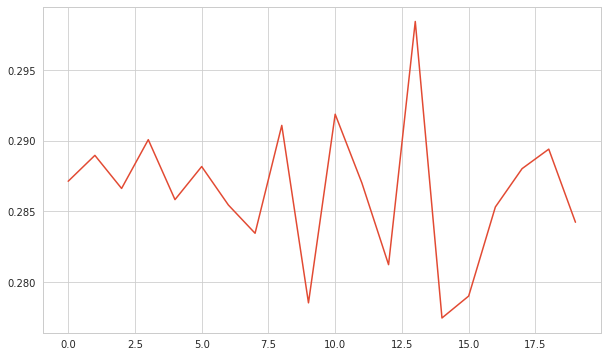

In [27]:
topic_modeler(10000, 5)

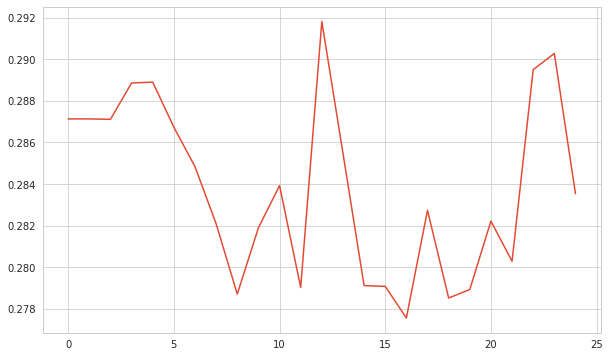

In [28]:
topic_modeler(10000, 3,.85,25, 1)

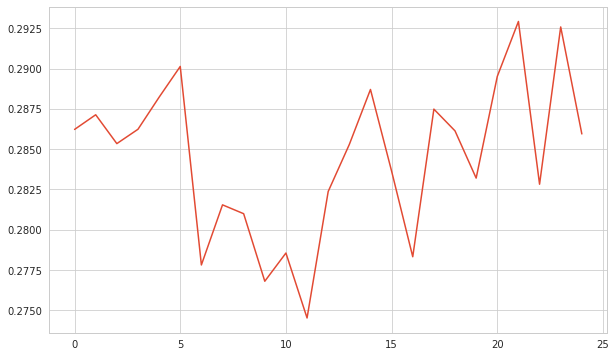

In [29]:
topic_modeler(10000, 3,.8,25, 1)

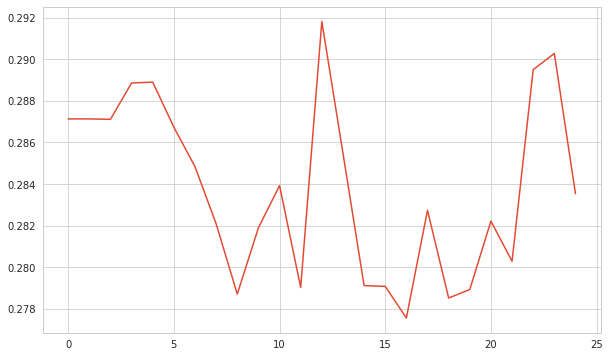

In [30]:
topic_modeler(10000, 3,.9,25, 1)

In [31]:
def nmf_featurizer(max_features=10000, min_df=3, max_df=.8, ngram_max = 2, n_components=18, n_words=10):
    vectorizer = TfidfVectorizer(tokenizer = lemmatize_text,
                             stop_words= review_stop_words,
                             max_features = max_features,
                             min_df = min_df,
                             max_df =  max_df,
                             ngram_range=(0, ngram_max)
                            )
    X = df['model_ready']
    X = vectorizer.fit_transform(X)
    
    nmf = NMF(
        n_components=n_components,
        init='nndsvd',
        random_state=12345,
        alpha = .1
        ).fit(X)

    W = nmf.fit_transform(X)
    H = nmf.components_
    topic_keywords = show_topics(vectorizer=vectorizer, lda_model=nmf, n_words=n_words)

    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

    Topics_theme = range(n_components)
    df_topic_keywords['topic_theme'] = Topics_theme
    df_topic_keywords.set_index('topic_theme', inplace=True)
    return df_topic_keywords.T

In [32]:
nmf_featurizer()

topic_theme,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Word 0,open,door,service,fit,sensor,model,power,buy,price,lasted,working,cook,time,popcorn,watt,happy,powerful,lot
Word 1,button,latch,repair,large,reheat,new,level,best,store,month,stopped,food,cooking,setting,1250,far,big,room
Word 2,door,close,warranty,space,sensor reheat,replace,power level,money,size,died,stopped working,heat,used,bag,1250 watt,purchase,big powerful,plenty
Word 3,push,door latch,month,size,defrost,pleased,inverter,brand,expected,second,quit working,evenly,long,button,watt power,happy purchase,powerful large,job
Word 4,door open,slam,day,counter,food,previous,power setting,want,best,lasted 10,quit,fast,second,popcorn setting,little,little,spacious,lot research
Word 5,open door,problem,customer,kitchen,function,new model,cooking,buy brand,right,10,month,cook food,cooking time,pop,6,review,room,lot room
Word 6,push button,shut,center,need,reheat function,replaced,setting,month,pleased,hope,month working,quickly,minute,popcorn button,cubic,quite,loud,plenty power
Word 7,button open,door close,week,needed,turbo,older,off,waste,delivery,previous lasted,far,cook fast,item,burn,cubic foot,inside,sure,lot power
Word 8,hand,hard,customer service,wanted,sensor cook,similar,set,pick,worth price,owned,6,heat food,long time,size,foot,quite happy,tray,option
Word 9,pull,broke,review,counter space,button,died,lower,waste money,worth,worked,completely,cook evenly,start,popcorn bag,watt sensor,pleased,turkey,research


In [34]:
nmf.components_

array([[1.02540066e-02, 1.02540066e-02, 3.05729476e-02, ...,
        1.51421815e-03, 1.30194718e-02, 1.46292809e-02],
       [0.00000000e+00, 0.00000000e+00, 5.50459132e-03, ...,
        8.46074580e-03, 1.85858965e-03, 6.27673187e-03],
       [1.02463179e-05, 1.02463179e-05, 9.69091582e-03, ...,
        4.41242914e-03, 0.00000000e+00, 4.80782730e-03],
       [2.56492031e-03, 2.56492031e-03, 8.43969730e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.95901925e-03, ...,
        0.00000000e+00, 0.00000000e+00, 7.82992610e-03]])

In [35]:
nmf.reconstruction_err_

41.93506167561453

In [37]:
X

AttributeError: components_ not found

array(["'enjoy", "'enjoy meal'", '0', ..., 'youtube', 'zap', 'zero'],
      dtype='<U22')

In [39]:
vocabulary = np.array(vectorizer.get_feature_names())

In [41]:
def hand_label_topics(H, vocabulary):
    '''
    Print the most influential words of each latent topic, and prompt the user
    to label each topic. The user should use their humanness to figure out what
    each latent topic is capturing.
    '''
    hand_labels = []
    for i, row in enumerate(H):
        top_five = np.argsort(row)[::-1][:20]
        print('topic', i)
        print('-->', ' '.join(vocabulary[top_five]))
        label = input('please label this topic: ')
        hand_labels.append(label)
        print()
    return hand_labels

In [50]:
hand_labels = hand_label_topics(H,vocabulary)

topic 0
--> power time popcorn setting level watt cooking power level button 1250 1250 watt cook lot inverter minute power setting bag off set using
please label this topic: 1

topic 1
--> door open latch close button push door latch door open hard open door problem slam shut door close broke start push button slam door opening closed
please label this topic: 2

topic 2
--> month lasted working warranty service buy died repair new day model worked 3 purchased review week ago problem stopped time
please label this topic: 3

topic 3
--> price large fit size big space powerful happy counter need needed kitchen far look pleased wanted lot larger expected model
please label this topic: 4

topic 4
--> sensor food cook reheat sensor reheat defrost heat function evenly button hot used sensor cook cook food heat food turbo cooking perfectly warm reheat function
please label this topic: 5



In [52]:
def softmax(v, temperature=1.0):
    '''
    A heuristic to convert arbitrary positive values into probabilities.
    See: https://en.wikipedia.org/wiki/Softmax_function
    '''
    expv = np.exp(v / temperature)
    s = np.sum(expv)
    return expv / s

In [ ]:
###### rand_reviews = np.random.choice(range(len(W)), 15)

def analyze_review(article_index, review_id, W, hand_labels):
    '''
    Print an analysis of a single Amazon review, including the review ID
    and a summary of which topics it represents. The topics are identified
    via the hand-labels which were assigned by the user.
    '''
    print(df.review_id[article_index])
    probs = softmax(W[article_index], temperature=0.01)
    for prob, label in zip(probs, hand_labels):
        print('--> {:.2f}% {}'.format(prob * 100, label))

In [53]:

        
review_ids = df.review_id
rand_reviews = np.random.choice(range(len(W)), 15)
        
for i in rand_reviews:
    analyze_review(i, review_ids, W, hand_labels)

R2IJHN564Q2K4Z
--> 99.88% 1
--> 0.01% 2
--> 0.01% 3
--> 0.01% 4
--> 0.09% 5
R1WFNX4UFVP9JJ
--> 0.23% 1
--> 0.26% 2
--> 0.80% 3
--> 98.49% 4
--> 0.22% 5
R3NVDW5V30EU9R
--> 1.06% 1
--> 0.47% 2
--> 67.26% 3
--> 30.74% 4
--> 0.47% 5
RVCTL92KRKPL6
--> 0.07% 1
--> 0.07% 2
--> 0.07% 3
--> 1.46% 4
--> 98.34% 5
R3ILTBHUK1GJ9M
--> 1.21% 1
--> 0.78% 2
--> 87.35% 3
--> 9.52% 4
--> 1.14% 5
RD7QE8FAKZ7I3
--> 3.80% 1
--> 1.52% 2
--> 89.72% 3
--> 2.48% 4
--> 2.47% 5
R2YLTST812SI0Z
--> 0.03% 1
--> 0.09% 2
--> 5.34% 3
--> 94.54% 4
--> 0.01% 5
R2LX3GV04K9QCD
--> 3.48% 1
--> 4.07% 2
--> 83.83% 3
--> 4.27% 4
--> 4.36% 5
RIMFYWWX56ELP
--> 0.15% 1
--> 0.15% 2
--> 6.01% 3
--> 0.41% 4
--> 93.27% 5
R1TC1I5WSUY3UG
--> 57.87% 1
--> 6.75% 2
--> 31.01% 3
--> 3.09% 4
--> 1.28% 5
RQHYSUQBSXSXV
--> 4.39% 1
--> 1.03% 2
--> 30.64% 3
--> 62.76% 4
--> 1.18% 5
R1AHCPXKU9LZZ2
--> 0.00% 1
--> 0.00% 2
--> 100.00% 3
--> 0.00% 4
--> 0.00% 5
R16D3XTCAB5VHT
--> 0.00% 1
--> 0.00% 2
--> 0.00% 3
--> 100.00% 4
--> 0.00% 5
R34K5WP5EQ6

In [33]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

NameError: name 'corpus' is not defined

### Goals

- Coherence scoring
- topic selection / tuning
- review and inte
- product feature scoring (topics with coherence score)
- topic percentage contribution score
- coherence score improvement (parameter tuning)